# Covid prediction using ML based on Symptoms
---

In [1]:
import numpy as np 
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import warnings
warnings.filterwarnings('ignore')

## Read the Dataframe
---

In [2]:
# covidData = pd.read_csv('corona_tested_individuals_ver_0083.english.csv',delimiter=",")
covidData_short = pd.read_csv('corona_tested_individuals_ver_006.english.csv',delimiter=",")

## Data Cleanup
---

In [3]:
covidData = covidData_short[covidData_short['gender'] != 'None'].copy(deep=True)
covidData = covidData[covidData['cough'] != 'None'].copy(deep=True)
covidData = covidData[covidData['fever'] != 'None'].copy(deep=True)
covidData = covidData[covidData['sore_throat'] != 'None'].copy(deep=True)
covidData = covidData[covidData['shortness_of_breath'] != 'None'].copy(deep=True)
covidData = covidData[covidData['head_ache'] != 'None'].copy(deep=True)
covidData = covidData[covidData['corona_result'] != 'None'].copy(deep=True)
covidData = covidData[covidData['corona_result'] != 'other'].copy(deep=True)
covidData = covidData[covidData['age_60_and_above'] != 'None'].copy(deep=True)
covidData = covidData[covidData['gender'] != 'None'].copy(deep=True)
covidData = covidData[covidData['test_indication'] != 'None'].copy(deep=True)
covidData['cough'] = covidData['cough'].astype(int)


## Drop the data
covidData = covidData.drop('test_date',axis=1).copy(deep=True)

covidData.shape


(136294, 9)

In [4]:
## Replace the String Data with numeric Data 
## -- gender                : female (0)   , male (1)
## -- corona_result         : negative(0), positive(1)
## -- test_indication       : Other(0), Abroad(1), Contact with confirmed(2)
## -- age_60_and_above      : Yes(0) , No(1) 


covidData_final = covidData.replace(to_replace=['female','negative','Other','Yes'],value=0)
covidData_final = covidData_final.replace(to_replace=['male','positive','Abroad','No'],value=1)
covidData_final = covidData_final.replace(to_replace=['Contact with confirmed'],value=2)

covidData_final = covidData_final.astype(int)

## Normalising the Data
---

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split

X = covidData_final.loc[:, covidData_final.columns != 'corona_result']
y = covidData_final.loc[:, covidData_final.columns == 'corona_result']
X = X.to_numpy()
y = y.to_numpy()
y = y.reshape((-1,))
#### For Cross Validation 
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3 , random_state=42)

## SUPPORT VECTOR CLASSIFICATIONS
#### The grid Search CV for all SVM Parameters 

In [72]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
pipeSVC = Pipeline([
("model", SVC(kernel = 'rbf',gamma = 'scale')
)
])


## Parameters to be optimised for the SVM 
## model__C = [1,10,100] , model__degree = [3,5,6] , model__kernel = ['linear','rbf']


## Scoring Metrics
scoring = ['accuracy','f1','roc_auc','precision','average_precision','recall']


## The grid search will be performed for the comibnation of these parmeters
##  3*3*2
param_grid={"model__kernel":['linear','rbf'] }


## GRID SEARCH FOR SVM 
gridCV_SVC = GridSearchCV(pipeSVC, param_grid, scoring=scoring, 
                          refit='roc_auc', return_train_score=True,cv =2)


gridCV_SVC.fit(X,y)
data_SVC = pd.DataFrame(gridCV_SVC.cv_results_)

In [78]:
cols = [col for col in data_SVC.columns if 'mean' in col]
data_SVC[cols[2:]].sort_values('mean_test_roc_auc',ascending=[0])


,mean_test_accuracy,mean_train_accuracy,mean_test_f1,mean_train_f1,mean_test_roc_auc,mean_train_roc_auc,mean_test_precision,mean_train_precision,mean_test_average_precision,mean_train_average_precision,mean_test_recall,mean_train_recall
1,0.955266,0.958736,0.676758,0.693835,0.820783,0.823634,0.778530,0.817031,0.608866,0.618326,0.598814,0.605214
0,0.944899,0.944899,0.464621,0.464621,0.751397,0.747455,0.943831,0.943831,0.535895,0.521155,0.313570,0.313570


In [51]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
pipeRF = Pipeline([
("model", RandomForestClassifier(n_estimators = 100,n_jobs = -1,max_depth=20,max_features='Auto')
)
])



pipeRF.get_params()
## Parameters to be optimised for the SVM 
# n_estimators = [50,100,200] , max_depth = [10,20,30] , max_features = [0.3,0.4,0.5]


## Scoring Metrics
scoring = ['accuracy','f1','roc_auc','precision','average_precision','recall']


# ## The grid search will be performed for the comibnation of these parmeters
# ##  3*3*2
param_grid={"model__n_estimators": [50,100,200,300], "model__max_features": ['auto','sqrt','log2']}


# ## GRID SEARCH FOR SVM 
gridCV_RF = GridSearchCV(pipeRF, param_grid, scoring=scoring, 
                          refit='roc_auc', return_train_score=True,cv =2)


gridCV_RF.fit(X,y)
data_RF = pd.DataFrame(gridCV_RF.cv_results_)

In [52]:
import pickle
with open ("RandomForest_result","wb") as f:
    pickle.dump(data_RF,f)

with open ("RandomForest_grid","wb") as f:
    pickle.dump(gridCV_RF,f)

## Logistic Regression
---

In [53]:
from sklearn.linear_model import LogisticRegression


# Create a Random forest Classifier
pipeLR = Pipeline([
("model", LogisticRegression(random_state=0,max_iter=200,penalty='none')
)
])

# 
# ## Parameters to be optimised for the SVM 
# ## Scoring Metrics
scoring = ['accuracy','f1','roc_auc','precision','average_precision','recall']


# # ## The grid search will be performed for the comibnation of these parmeters
# # ##  3*3*2
param_grid={"model__penalty": ['l1','l2','none'],  "model__solver": ['newton-cg', 'lbfgs', 'liblinear'], "model__C":[100,10,1,0.1] }


# ## GRID SEARCH FOR SVM 
gridCV_LR = GridSearchCV(pipeLR, param_grid, scoring=scoring, 
                          refit='roc_auc', return_train_score=True,cv =2)


gridCV_LR.fit(X,y)
data_LR = pd.DataFrame(gridCV_LR.cv_results_)

In [79]:
cols = [col for col in data_LR.columns if 'mean' in col]
data_LR[cols[2:]].sort_values('mean_test_roc_auc',ascending=[0])


,mean_test_accuracy,mean_train_accuracy,mean_test_f1,mean_train_f1,mean_test_roc_auc,mean_train_roc_auc,mean_test_precision,mean_train_precision,mean_test_average_precision,mean_train_average_precision,mean_test_recall,mean_train_recall
34,0.949756,0.950783,0.574610,0.583085,0.880958,0.881217,0.830029,0.848714,0.656218,0.675450,0.442217,0.447770
16,0.949756,0.950783,0.574610,0.583085,0.880958,0.881217,0.830029,0.848714,0.656218,0.675450,0.442217,0.447770
25,0.949756,0.950783,0.574610,0.583085,0.880958,0.881217,0.830029,0.848714,0.656218,0.675450,0.442217,0.447770
7,0.949756,0.950783,0.574610,0.583085,0.880958,0.881217,0.830029,0.848714,0.656218,0.675450,0.442217,0.447770
5,0.949756,0.950783,0.574610,0.583085,0.880928,0.881201,0.830029,0.848714,0.656005,0.675280,0.442217,0.447770
11,0.949756,0.950783,0.574610,0.583085,0.880928,0.881201,0.830029,0.848714,0.656005,0.675280,0.442217,0.447770
14,0.949756,0.950783,0.574610,0.583085,0.880928,0.881201,0.830029,0.848714,0.656003,0.675277,0.442217,0.447770
33,0.949756,0.950783,0.574610,0.583085,0.880928,0.881201,0.830029,0.848714,0.656005,0.675280,0.442217,0.447770
24,0.949756,0.950783,0.574610,0.583085,0.880928,0.881201,0.830029,0.848714,0.656005,0.675280,0.442217,0.447770
3,0.949756,0.950783,0.574610,0.583085,0.880928,0.881201,0.830029,0.848714,0.656005,0.675280,0.442217,0.447770


In [54]:
import pickle
with open ("LogReg_result","wb") as f:
    pickle.dump(data_LR,f)

with open ("LogReg_grid","wb") as f:
    pickle.dump(gridCV_LR,f)

## Decision Tree
---

In [57]:
from sklearn.tree import DecisionTreeClassifier
pipeDT = Pipeline([
("model", DecisionTreeClassifier(random_state=0)
)
])

pipeDT.get_params()
# 
# ## Parameters to be optimised for the SVM 
# ## Scoring Metrics
scoring = ['accuracy','f1','roc_auc','precision','average_precision','recall']


# # # ## The grid search will be performed for the comibnation of these parmeters
# # # ##  3*3*2
param_grid={"model__max_depth": [3,4,5,6],  "model__min_samples_leaf": [1,2,3], "model__max_leaf_nodes":[5,10] }


# # ## GRID SEARCH FOR SVM 
gridCV_DT = GridSearchCV(pipeDT, param_grid, scoring=scoring, 
                          refit='roc_auc', return_train_score=True,cv =2)


gridCV_DT.fit(X,y)
data_DT = pd.DataFrame(gridCV_DT.cv_results_)

In [81]:
colvals = [col for col in data_DT.columns if 'mean' in col]
data_DT[colvals[2:]].sort_values('mean_test_roc_auc',ascending=[0])

,mean_test_accuracy,mean_train_accuracy,mean_test_f1,mean_train_f1,mean_test_roc_auc,mean_train_roc_auc,mean_test_precision,mean_train_precision,mean_test_average_precision,mean_train_average_precision,mean_test_recall,mean_train_recall
17,0.955273,0.957005,0.682392,0.682959,0.873550,0.873675,0.773528,0.798733,0.641553,0.644800,0.612836,0.601732
16,0.955273,0.957005,0.682392,0.682959,0.873550,0.873675,0.773528,0.798733,0.641553,0.644800,0.612836,0.601732
15,0.955273,0.957005,0.682392,0.682959,0.873550,0.873675,0.773528,0.798733,0.641553,0.644800,0.612836,0.601732
23,0.954782,0.956711,0.677319,0.679747,0.873502,0.874584,0.773088,0.797800,0.634602,0.647842,0.605590,0.597779
22,0.954782,0.956711,0.677319,0.679747,0.873502,0.874584,0.773088,0.797800,0.634602,0.647842,0.605590,0.597779
21,0.954782,0.956711,0.677319,0.679747,0.873502,0.874584,0.773088,0.797800,0.634602,0.647842,0.605590,0.597779
9,0.953938,0.955618,0.669302,0.669037,0.835879,0.846945,0.769450,0.796334,0.602708,0.622767,0.594391,0.580651
10,0.953938,0.955618,0.669302,0.669037,0.835879,0.846945,0.769450,0.796334,0.602708,0.622767,0.594391,0.580651
11,0.953938,0.955618,0.669302,0.669037,0.835879,0.846945,0.769450,0.796334,0.602708,0.622767,0.594391,0.580651
14,0.953600,0.952859,0.677734,0.670385,0.833489,0.844584,0.737695,0.739519,0.543461,0.560770,0.626859,0.613778


In [58]:
import pickle
with open ("DessTree_result","wb") as f:
    pickle.dump(data_DT,f)

with open ("DessTree","wb") as f:
    pickle.dump(gridCV_DT,f)

## KNN
---

In [60]:
from sklearn.neighbors import KNeighborsClassifier

pipeKNN = Pipeline([
("model", KNeighborsClassifier(n_neighbors=3)
)
])

pipeKNN.get_params()

scoring = ['accuracy','f1','roc_auc','precision','average_precision','recall']


# # # ## The grid search will be performed for the comibnation of these parmeters
# # # ##  3*3*2
param_grid={"model__metric": ['euclidean','manhattan','minkowski'],  "model__n_neighbors": [3,5,10], "model__p":[1,2,3] }


# # ## GRID SEARCH FOR SVM 
gridCV_KNN = GridSearchCV(pipeKNN, param_grid, scoring=scoring, 
                          refit='roc_auc', return_train_score=True,cv =2)


gridCV_KNN.fit(X,y)
data_KNN = pd.DataFrame(gridCV_KNN.cv_results_)

In [82]:
colvals = [col for col in data_KNN.columns if 'mean' in col]
data_KNN[colvals[2:]].sort_values('mean_test_roc_auc',ascending=[0])

,mean_test_accuracy,mean_train_accuracy,mean_test_f1,mean_train_f1,mean_test_roc_auc,mean_train_roc_auc,mean_test_precision,mean_train_precision,mean_test_average_precision,mean_train_average_precision,mean_test_recall,mean_train_recall
26,0.951935,0.956469,0.645435,0.671162,0.878335,0.880989,0.772560,0.809792,0.642527,0.673049,0.559194,0.579240
25,0.951935,0.956469,0.645435,0.671162,0.878335,0.880989,0.772560,0.809792,0.642527,0.673049,0.559194,0.579240
24,0.951935,0.956469,0.645435,0.671162,0.878335,0.880989,0.772560,0.809792,0.642527,0.673049,0.559194,0.579240
6,0.951935,0.956469,0.645435,0.671162,0.878335,0.880989,0.772560,0.809792,0.642527,0.673049,0.559194,0.579240
7,0.951935,0.956469,0.645435,0.671162,0.878335,0.880989,0.772560,0.809792,0.642527,0.673049,0.559194,0.579240
8,0.951935,0.956469,0.645435,0.671162,0.878335,0.880989,0.772560,0.809792,0.642527,0.673049,0.559194,0.579240
17,0.951935,0.956469,0.645435,0.671162,0.878335,0.880989,0.772560,0.809792,0.642527,0.673049,0.559194,0.579240
16,0.951935,0.956469,0.645435,0.671162,0.878335,0.880989,0.772560,0.809792,0.642527,0.673049,0.559194,0.579240
15,0.951935,0.956469,0.645435,0.671162,0.878335,0.880989,0.772560,0.809792,0.642527,0.673049,0.559194,0.579240
14,0.949741,0.951238,0.652188,0.670373,0.852895,0.859696,0.708358,0.716856,0.584179,0.613512,0.604273,0.630623


In [68]:
import pickle
with open ("KNN_result","wb") as f:
    pickle.dump(data_KNN,f)

with open ("KNN","wb") as f:
    pickle.dump(gridCV_KNN,f)

## Gradient Boosting
---

In [62]:
from sklearn.datasets import make_hastie_10_2
from sklearn.ensemble import GradientBoostingClassifier



pipeXG = Pipeline([
("model",GradientBoostingClassifier(n_estimators=100, learning_rate=0.01,
max_depth=5)
)
])

scoring = ['accuracy','f1','roc_auc','precision','average_precision','recall']


# # # ## The grid search will be performed for the comibnation of these parmeters
# # # ##  3*3*2
param_grid={"model__n_estimators": [50,100,200],  "model__max_depth": [3,5,10,20] }


# # ## GRID SEARCH FOR SVM 
gridCV_XG = GridSearchCV(pipeXG, param_grid, scoring=scoring, 
                          refit='roc_auc', return_train_score=True,cv =2)


gridCV_XG.fit(X,y)
data_XG = pd.DataFrame(gridCV_XG.cv_results_)



In [69]:
import pickle
with open ("GXG_result","wb") as f:
    pickle.dump(data_XG,f)

with open ("GXG","wb") as f:
    pickle.dump(gridCV_XG,f)

## XGBoost
---

In [ ]:
from xgboost import XGBClassifier

pipeXGB_Boost = Pipeline([
("model",XGBClassifier(num_leaves=50,n_esmin_data_in_leaf = 10, feature_fraction = 0.2, bagging_fraction = 0.8,bagging_freq=5,
                       learning_rate=0.05,num_boost_round=300,early_stopping_round=5)
)
])


scoring = ['accuracy','f1','roc_auc','precision','average_precision','recall']


# # # ## The grid search will be performed for the comibnation of these parmeters
# # # ##  3*3*2
param_grid={"model__num_leaves": [50,100,200],  "model__feature_fraction": [0.1,0.2,0.33] , "model__num_boost_round" : [200,300,400]}


# # ## GRID SEARCH FOR SVM 
gridCV_XGB_Boost = GridSearchCV(pipeXGB_Boost, param_grid, scoring=scoring, 
                          refit='roc_auc', return_train_score=True,cv =2)


gridCV_XGB_Boost.fit(X,y)
data_XGB_Boost = pd.DataFrame(gridCV_XGB_Boost.cv_results_)

In [84]:
colvals = [col for col in data_XGB_Boost.columns if 'mean' in col]
data_XGB_Boost[colvals[2:]].sort_values('mean_test_roc_auc',ascending=[0])

,mean_test_accuracy,mean_train_accuracy,mean_test_f1,mean_train_f1,mean_test_roc_auc,mean_train_roc_auc,mean_test_precision,mean_train_precision,mean_test_average_precision,mean_train_average_precision,mean_test_recall,mean_train_recall
0,0.955185,0.958773,0.674568,0.693286,0.912753,0.915021,0.781395,0.819465,0.716851,0.736474,0.593826,0.602955
14,0.955185,0.958773,0.674568,0.693286,0.912753,0.915021,0.781395,0.819465,0.716851,0.736474,0.593826,0.602955
25,0.955185,0.958773,0.674568,0.693286,0.912753,0.915021,0.781395,0.819465,0.716851,0.736474,0.593826,0.602955
24,0.955185,0.958773,0.674568,0.693286,0.912753,0.915021,0.781395,0.819465,0.716851,0.736474,0.593826,0.602955
23,0.955185,0.958773,0.674568,0.693286,0.912753,0.915021,0.781395,0.819465,0.716851,0.736474,0.593826,0.602955
22,0.955185,0.958773,0.674568,0.693286,0.912753,0.915021,0.781395,0.819465,0.716851,0.736474,0.593826,0.602955
21,0.955185,0.958773,0.674568,0.693286,0.912753,0.915021,0.781395,0.819465,0.716851,0.736474,0.593826,0.602955
20,0.955185,0.958773,0.674568,0.693286,0.912753,0.915021,0.781395,0.819465,0.716851,0.736474,0.593826,0.602955
19,0.955185,0.958773,0.674568,0.693286,0.912753,0.915021,0.781395,0.819465,0.716851,0.736474,0.593826,0.602955
18,0.955185,0.958773,0.674568,0.693286,0.912753,0.915021,0.781395,0.819465,0.716851,0.736474,0.593826,0.602955


In [71]:
import pickle
with open ("XGB_Boost_result","wb") as f:
    pickle.dump(data_XGB_Boost,f)

with open ("XGB_Boost","wb") as f:
    pickle.dump(gridCV_XGB_Boost,f)

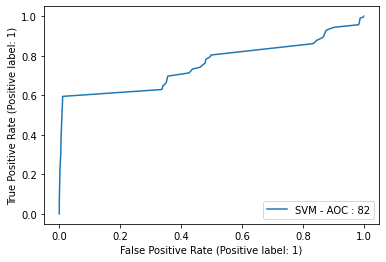

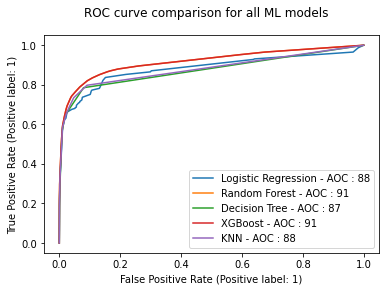

In [93]:
###### PLOTTING ALGORITHM 
from sklearn.metrics import *

fig = plot_roc_curve( gridCV_SVC, X, y , label="SVM - AOC : " + str(82))
fig = plot_roc_curve( gridCV_LR, X, y , label="Logistic Regression - AOC : "  + str(88) )
fig = plot_roc_curve( gridCV_RF, X, y , ax = fig.ax_ , label="Random Forest - AOC : "  + str(91) )
fig = plot_roc_curve( gridCV_DT, X, y , ax = fig.ax_ , label="Decision Tree - AOC : " + str(87))
fig = plot_roc_curve( gridCV_XGB_Boost, X, y , ax = fig.ax_ , label="XGBoost - AOC : " + str(91))
fig = plot_roc_curve( gridCV_KNN, X, y , ax = fig.ax_ , label="KNN - AOC : " + str(88))
fig.figure_.suptitle("ROC curve comparison for all ML models")
plt.show() 

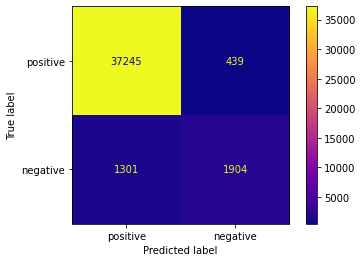

In [95]:
plot_confusion_matrix(gridCV_XGB_Boost,X_test,y_test,display_labels=['positive','negative'],cmap='plasma')